Copyright (C) 2025 Advanced Micro Devices, Inc. All rights reserved.
Portions of this notebook consist of AI-generated content.

Permission is hereby granted, free of charge, to any person obtaining a copy

of this software and associated documentation files (the "Software"), to deal

in the Software without restriction, including without limitation the rights

to use, copy, modify, merge, publish, distribute, sublicense, and/or sell

copies of the Software, and to permit persons to whom the Software is

furnished to do so, subject to the following conditions:



The above copyright notice and this permission notice shall be included in all

copies or substantial portions of the Software.



THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR

IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,

FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE

AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER

LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,

OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE

SOFTWARE.

# DL07 Word2Vec
### Lab Description
This laboratory exercise introduces **Word2Vec**, a powerful representation learning technique that maps words to dense vectors in a continuous vector space, capturing semantic relationships. Word2Vec has become a foundational technique in natural language processing.

In this hands-on lab, you will process the `Text8` dataset, train a Word2Vec model using the **Skip-gram** architecture and **CBOW** architecture with negative sampling, and visualize the resulting word embeddings to explore semantic similarity.

### What you can expect to learn
- Theoretical Understanding: Understand the principles behind Word2Vec, including the Skip-gram model and negative sampling.

- Data Preprocessing: Learn to tokenize and prepare a large text corpus (Text8) for word embedding training.

- Training Word2Vec: Gain experience in implementing or using Word2Vec models using frameworks such as Gensim or PyTorch.

- Embedding Analysis: Explore vector arithmetic (e.g., "king" - "man" + "woman" ≈ "queen") and visualize embeddings using dimensionality reduction techniques like PCA or t-SNE.

## Import necessary libraries

In [ ]:
import collections
import os

import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)
print("GPU Name:", torch.cuda.get_device_name(0))

## Required Dataset
We use the `Text8` dataset for this lab. It contains the first 100MB of cleaned Wikipedia text, preprocessed to include only lowercase English words (no punctuation, numbers, or special characters), and is commonly used for training and evaluating word embedding models.

The dataset will be automatically downloaded using the following script:

In [2]:
import contextlib
import urllib.request
import zipfile

DOWNLOAD_URL = "http://mattmahoney.net/dc/"
DATA_FOLDER = os.path.expanduser("~/data")
FILE_NAME = "text8.zip"
EXPECTED_BYTES = 31344016


def make_dir(path):
    """Create a directory if there isn't one already."""
    with contextlib.suppress(OSError):
        os.mkdir(path)


def download(file_name, expected_bytes):
    """Download the dataset text8 if it's not already downloaded"""
    local_file_path = os.path.join(DATA_FOLDER, file_name)
    if os.path.exists(local_file_path):
        print("Dataset ready")
        return local_file_path

    file_name, _ = urllib.request.urlretrieve(os.path.join(DOWNLOAD_URL, file_name), local_file_path)
    file_stat = os.stat(local_file_path)

    if file_stat.st_size == expected_bytes:
        print("Successfully downloaded the file", file_name)
    else:
        raise Exception("File " + file_name + " might be corrupted. Try downloading it with a browser.")
    return local_file_path


make_dir(DATA_FOLDER)
file_path = download(FILE_NAME, EXPECTED_BYTES)

# Extract and read text8
with zipfile.ZipFile(file_path) as f:
    text = f.read(f.namelist()[0]).decode("utf-8")

tokens = text.strip().split()
print("Text8 tokens:", len(tokens))
print("Sample:", tokens[:20])

Dataset ready
Text8 tokens: 17005207
Sample: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english']


### Vocabulary and Negative Sampling Setup

Before we can train Word2Vec, we need two key components:

1. **Vocabulary Builder (`Vocab` class)**  
   - Takes all tokens from the corpus and counts their frequencies.  
   - Creates two mappings:
     - `word2id`: from word → index  
     - `id2word`: from index → word  
   - Stores how many times each word appears (`counts`).  
   - This lets us convert raw text into integer IDs for training.

2. **Negative Sampling Table (`make_negative_table`)**  
   - Word2Vec does not use a full softmax (too expensive for large vocabularies).  
   - Instead, it uses *negative sampling*: for each positive (center, context) pair, we also draw several random “negative” words.  
   - To make this efficient, we build a large lookup table of word IDs where frequent words appear more often.  
   - The probability for each word is proportional to its frequency raised to the power of 0.75 (a heuristic from the original Word2Vec paper).  
   - During training, we can then sample negatives quickly by choosing random entries from this table.

Together, this step converts raw text into **IDs** and prepares the **negative word distribution** that will be used in the loss function.


In [3]:
# Vocabulary & subsampling/negative sampling utils
class Vocab:
    def __init__(self, tokens: list[str], min_count: int = 1):
        counter = collections.Counter(tokens)
        self.word2id = {}
        self.id2word = []
        for w, c in counter.items():
            if c >= min_count:
                self.word2id[w] = len(self.id2word)
                self.id2word.append(w)
        self.counts = np.zeros(len(self.id2word), dtype=np.int64)
        for w, c in counter.items():
            if w in self.word2id:
                self.counts[self.word2id[w]] = c
        self.total = int(self.counts.sum())

    def __len__(self):
        return len(self.id2word)

    def encode(self, tokens: list[str]) -> list[int]:
        return [self.word2id[w] for w in tokens if w in self.word2id]

    def decode(self, ids: list[int]) -> list[str]:
        return [self.id2word[i] for i in ids]


# Build vocab
vocab = Vocab(tokens, min_count=1)
ids = vocab.encode(tokens)
print("Vocab size:", len(vocab), "Encoded tokens:", len(ids))


# Negative sampling table (unigram^0.75)
def make_negative_table(counts: np.ndarray, table_size: int = 1_000_000) -> np.ndarray:
    pow_freq = np.power(counts, 0.75)
    probs = pow_freq / pow_freq.sum()
    table = np.zeros(table_size, dtype=np.int32)
    cumulative = np.cumsum(probs)
    j = 0
    for i in range(table_size):
        while j < len(cumulative) and (i / table_size) > cumulative[j]:
            j += 1
        table[i] = j if j < len(counts) else len(counts) - 1
    return table


NEG_TABLE = make_negative_table(vocab.counts, table_size=min(200000, 1000 * max(1, len(vocab))))
rng = np.random.default_rng(123)

Vocab size: 253854 Encoded tokens: 17005207


### Building Datasets for Skip-gram and CBOW (with Negative Sampling)

Now that we have a vocabulary and a negative sampling table, we need to create the actual **training examples**.

1. **Skip-gram pairs (`generate_skipgram_pairs`)**  
   - For each word (the *center*), look at a sliding window around it.  
   - Every neighbor in that window becomes a *positive context word*.  
   - Example: In the sentence *"the cat sat on the mat"*, with `window=2`:  
     - Center = "sat" → context = {"the", "cat", "on", "the"}  
     - Training pairs: ("sat","the"), ("sat","cat"), ("sat","on"), ("sat","the")

2. **CBOW pairs (`generate_cbow_pairs`)**  
   - The opposite of skip-gram: use the *context words* to predict the *center word*.  
   - Same example with `window=2`:  
     - Context = {"the", "cat", "on", "the"}, target = "sat"

3. **Datasets (`SkipGramDataset`, `CBOWDataset`)**  
   - Each dataset stores the pairs and adds **negative samples** (random words from the negative sampling table).  
   - For skip-gram: each item = `(center, positive, negatives)`  
   - For CBOW: each item = `(context_vector, target, negatives)`  
     - Contexts are padded or truncated to a fixed length (`max_ctx`) so they fit into batches.

4. **Collate functions (`collate_skipgram`, `collate_cbow`)**  
   - When building a batch, PyTorch’s `DataLoader` calls these to merge individual samples.  
   - They stack everything into tensors of shape:  
     - Skip-gram: `(centers, positives, negatives)`  
     - CBOW: `(contexts, targets, negatives)`

👉 With this setup, we can now feed batches of word IDs (with positives and negatives) into our Word2Vec model for training.


In [4]:
# Dataset builders for Skip-gram and CBOW with negative sampling
def generate_skipgram_pairs(ids: list[int], window: int = 2) -> list[tuple[int, int]]:
    pairs = []
    for i, center in enumerate(ids):
        left = max(0, i - window)
        right = min(len(ids), i + window + 1)
        for j in range(left, right):
            if j != i:
                pairs.append((center, ids[j]))
    return pairs


def generate_cbow_pairs(ids: list[int], window: int = 2) -> list[tuple[list[int], int]]:
    pairs = []
    for i in range(len(ids)):
        left = max(0, i - window)
        right = min(len(ids), i + window + 1)
        context = [ids[j] for j in range(left, right) if j != i]
        if context:
            pairs.append((context, ids[i]))
    return pairs


class SkipGramDataset(Dataset):
    def __init__(self, pairs: list[tuple[int, int]], neg_k: int = 5):
        self.pairs = pairs
        self.neg_k = neg_k

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        c, pos = self.pairs[idx]
        negs = rng.choice(NEG_TABLE, size=self.neg_k, replace=True).tolist()
        # Avoid accidental positives
        negs = [n if n != pos else (n + 1) % len(vocab) for n in negs]
        return c, pos, torch.tensor(negs, dtype=torch.long)


def collate_skipgram(batch):
    centers = torch.tensor([b[0] for b in batch], dtype=torch.long)
    positives = torch.tensor([b[1] for b in batch], dtype=torch.long)
    negatives = torch.stack([b[2] for b in batch], dim=0)
    return centers, positives, negatives


class CBOWDataset(Dataset):
    def __init__(self, pairs: list[tuple[list[int], int]], neg_k: int = 5, max_ctx: int = 8):
        self.pairs = pairs
        self.neg_k = neg_k
        self.max_ctx = max_ctx

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        ctx, target = self.pairs[idx]
        # Truncate/pad context to a fixed size for batching
        if len(ctx) > self.max_ctx:
            ctx = ctx[: self.max_ctx]
        pad_len = self.max_ctx - len(ctx)
        ctx = ctx + [0] * pad_len
        negs = rng.choice(NEG_TABLE, size=self.neg_k, replace=True).tolist()
        negs = [n if n != target else (n + 1) % len(vocab) for n in negs]
        return (
            torch.tensor(ctx, dtype=torch.long),
            torch.tensor(target, dtype=torch.long),
            torch.tensor(negs, dtype=torch.long),
        )


def collate_cbow(batch):
    ctx = torch.stack([b[0] for b in batch], dim=0)  # [B, C]
    tgt = torch.stack([b[1] for b in batch], dim=0)  # [B]
    neg = torch.stack([b[2] for b in batch], dim=0)  # [B, K]
    return ctx, tgt, neg

### Models: Skip-gram and CBOW with Negative Sampling

Now we define the **neural network models** for Word2Vec.  
Both models use two embedding matrices:

- **Input embeddings (`in_embed`)** – how each word is represented when it is the *input* (center or context).  
- **Output embeddings (`out_embed`)** – how each word is represented when it is the *predicted output* (target word or negative sample).  

The embeddings are trained jointly so that words appearing in similar contexts have similar vectors.

---

1. **Skip-gram model (`SkipGramNS`)**
   - Input: a *center word* ID.  
   - Output: predicts its *context words*.  
   - For each pair:
     - Compute similarity between the center embedding and the positive context embedding.  
     - Compute similarity between the center embedding and several negative word embeddings.  
   - Returns:
     - `pos_score`: similarity with the true context words.  
     - `neg_score`: similarity with random negative words.  

2. **CBOW model (`CBOWNS`)**
   - Input: a set of *context words* (averaged into one vector).  
   - Output: predicts the *center word*.  
   - Same negative sampling setup:
     - Positive score = similarity between averaged context vector and target.  
     - Negative scores = similarity between averaged context vector and random words.  

3. **Negative Sampling Loss (`ns_loss`)**

   **Formula:**  

   $$
   L = -\log \sigma(\text{pos}) - \sum \log \sigma(-\text{neg})
   $$

   - Encourages the model to give high scores for true pairs and low scores for random negatives.  
   - Much cheaper than full softmax over the entire vocabulary.  

---

👉 **In summary:**
- **Skip-gram:** one word → predict its neighbors.  
- **CBOW:** neighbors → predict the middle word.  
Both are trained with negative sampling to make learning efficient on large vocabularies.
g to make learning efficient on large vocabularies.


In [5]:
# Models: Skip-gram and CBOW with negative sampling
class SkipGramNS(nn.Module):
    def __init__(self, vocab_size: int, dim: int = 128):
        super().__init__()
        self.in_embed = nn.Embedding(vocab_size, dim)
        self.out_embed = nn.Embedding(vocab_size, dim)
        nn.init.uniform_(self.in_embed.weight, -0.5 / dim, 0.5 / dim)
        nn.init.zeros_(self.out_embed.weight)

    def forward(self, center, pos, neg):
        # center: [B], pos: [B], neg: [B, K]
        v_c = self.in_embed(center)  # [B, D]
        v_p = self.out_embed(pos)  # [B, D]
        v_n = self.out_embed(neg)  # [B, K, D]
        pos_score = torch.sum(v_c * v_p, dim=1)  # [B]
        neg_score = torch.bmm(v_n, v_c.unsqueeze(2)).squeeze(2)  # [B, K]
        return pos_score, neg_score


class CBOWNS(nn.Module):
    def __init__(self, vocab_size: int, dim: int = 128):
        super().__init__()
        self.in_embed = nn.Embedding(vocab_size, dim)
        self.out_embed = nn.Embedding(vocab_size, dim)
        nn.init.uniform_(self.in_embed.weight, -0.5 / dim, 0.5 / dim)
        nn.init.zeros_(self.out_embed.weight)

    def forward(self, context, target, neg):
        # context: [B, C], target: [B], neg: [B, K]
        v_ctx = self.in_embed(context).mean(dim=1)  # [B, D]
        v_tgt = self.out_embed(target)  # [B, D]
        v_neg = self.out_embed(neg)  # [B, K, D]
        pos_score = torch.sum(v_ctx * v_tgt, dim=1)  # [B]
        neg_score = torch.bmm(v_neg, v_ctx.unsqueeze(2)).squeeze(2)  # [B, K]
        return pos_score, neg_score


def ns_loss(pos_score, neg_score):
    # Negative sampling loss = -log sigma(pos) - sum log sigma(-neg)
    pos_loss = torch.nn.functional.logsigmoid(pos_score).mean()
    neg_loss = torch.nn.functional.logsigmoid(-neg_score).mean()
    return -(pos_loss + neg_loss)

### Building Training Batches (Skip-gram vs CBOW)

This block prepares **pairs → datasets → dataloaders → model** based on the selected modethe optimizer.

**Pipeline (per mode)**
1. **Pair generation**  
   - Skip-gram: `(center, context)` for all neighbors within `WINDOW`.  
   - CBOW: `(context_list, target)` with context size up to `2*WINDOW`.
2. **Dataset**  
   - Adds `NEG_K` negative samples per item using the prebuilt unigram^0.75 table.
   - CBOW pads/truncates the context to a fixed length (`max_ctx = 2*WINDOW`) for batching.
3. **DataLoader**  
   - Uses a mode-specific `collate_fn` to stack items into tensors.
   - `drop_last=True` keeps batch shapes consistent for efficient training.
4. **Model selection**  
   - `SkipGramNS(vocab_size, dim)` or `CBOWNS(vocab_size, dim)` is moved to `DEVICE`.

The final print shows how many training pairs were generated, the vocabulary size, and which mode is active.


In [ ]:
# Build training data for both modes
WINDOW = 2
NEG_K = 5
MODE = "cbow"  # "skipgram" or "cbow"
EMBED_DIM = 128
BATCH_SIZE = 256
EPOCHS = 1
LR = 2e-3

if MODE == "skipgram":
    pairs = generate_skipgram_pairs(ids, window=WINDOW)
    ds = SkipGramDataset(pairs, neg_k=NEG_K)
    dl = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_skipgram, drop_last=True)
    model = SkipGramNS(len(vocab), dim=EMBED_DIM).to(DEVICE)
elif MODE == "cbow":
    pairs = generate_cbow_pairs(ids, window=WINDOW)
    ds = CBOWDataset(pairs, neg_k=NEG_K, max_ctx=2 * WINDOW)
    dl = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_cbow, drop_last=True)
    model = CBOWNS(len(vocab), dim=EMBED_DIM).to(DEVICE)
else:
    raise ValueError("MODE must be 'skipgram' or 'cbow'")

print(f"Pairs: {len(ds)} | Vocab: {len(vocab)} | Mode: {MODE}")

Pairs: 17005207 | Vocab: 253854 | Mode: cbow


## Training Loop

You can interrupt training with KeyboardInterrupt if one epoch takes too long. By around 15,000 steps, you can get acceptable results.

In [11]:
# Training
opt = torch.optim.AdamW(model.parameters(), lr=LR)
model.train()
for epoch in range(1, EPOCHS + 1):
    total_loss = 0.0
    for step, batch in enumerate(dl, 1):
        if MODE == "skipgram":
            center, pos, neg = [b.to(DEVICE) for b in batch]
            pos_s, neg_s = model(center, pos, neg)
        else:
            ctx, tgt, neg = [b.to(DEVICE) for b in batch]
            pos_s, neg_s = model(ctx, tgt, neg)

        loss = ns_loss(pos_s, neg_s)
        opt.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        opt.step()

        total_loss += loss.item()
        if step % 1000 == 0:
            print(f"Epoch {epoch} | Step {step} | Loss {total_loss / step:.4f}")
        # print(f"[Epoch {epoch}] Avg Loss: {total_loss/max(1, step):.4f}")

Epoch 1 | Step 1000 | Loss 1.1807
Epoch 1 | Step 2000 | Loss 1.1219
Epoch 1 | Step 3000 | Loss 1.0860
Epoch 1 | Step 4000 | Loss 1.0591
Epoch 1 | Step 5000 | Loss 1.0377
Epoch 1 | Step 6000 | Loss 1.0199
Epoch 1 | Step 7000 | Loss 1.0047
Epoch 1 | Step 8000 | Loss 0.9914
Epoch 1 | Step 9000 | Loss 0.9796


KeyboardInterrupt: 

## Results

In [12]:
# Utilities: get similar words by cosine similarity
@torch.no_grad()
def get_embeddings(model) -> np.ndarray:
    if hasattr(model, "in_embed"):
        return model.in_embed.weight.detach().cpu().numpy()
    raise AttributeError("Model has no in_embed")


@torch.no_grad()
def most_similar(query: str, topk: int = 10) -> list[tuple[str, float]]:
    if query not in vocab.word2id:
        return []
    emb = get_embeddings(model)
    qid = vocab.word2id[query]
    qv = emb[qid]
    # cosine similarity
    norms = np.linalg.norm(emb, axis=1) * np.linalg.norm(qv) + 1e-9
    sims = (emb @ qv) / norms
    idx = np.argsort(-sims)[: topk + 1]
    results = []
    for i in idx:
        if i == qid:  # skip self once
            continue
        results.append((vocab.id2word[i], float(sims[i])))
        if len(results) == topk:
            break
    return results


print("Similar to 'life':", most_similar("life", topk=5))

Similar to 'life': [('career', 0.7376438975334167), ('death', 0.7352918982505798), ('dreams', 0.7197412252426147), ('softening', 0.7147207260131836), ('westbury', 0.7122626900672913)]


In [13]:
# Word analogies: a is to b as c is to ?
@torch.no_grad()
def analogy(a: str, b: str, c: str, topk: int = 5) -> list[tuple[str, float]]:
    for w in (a, b, c):
        if w not in vocab.word2id:
            return []
    emb = get_embeddings(model)
    va, vb, vc = [emb[vocab.word2id[w]] for w in (a, b, c)]
    target = vb - va + vc
    norms = np.linalg.norm(emb, axis=1) * (np.linalg.norm(target) + 1e-9) + 1e-9
    sims = (emb @ target) / norms
    # Exclude a, b, c
    mask = np.ones(len(vocab), dtype=bool)
    mask[vocab.word2id[a]] = False
    mask[vocab.word2id[b]] = False
    mask[vocab.word2id[c]] = False
    sims_masked = np.where(mask, sims, -np.inf)
    idx = np.argsort(-sims_masked)[:topk]
    return [(vocab.id2word[i], float(sims[i])) for i in idx]


print("Analogy: king - man + woman ≈", analogy("man", "king", "woman", 5))

Analogy: king - man + woman ≈ [('queen', 0.852251410484314), ('emperor', 0.8468197584152222), ('chancellor', 0.8401687145233154), ('reagan', 0.826861560344696), ('iii', 0.8267659544944763)]


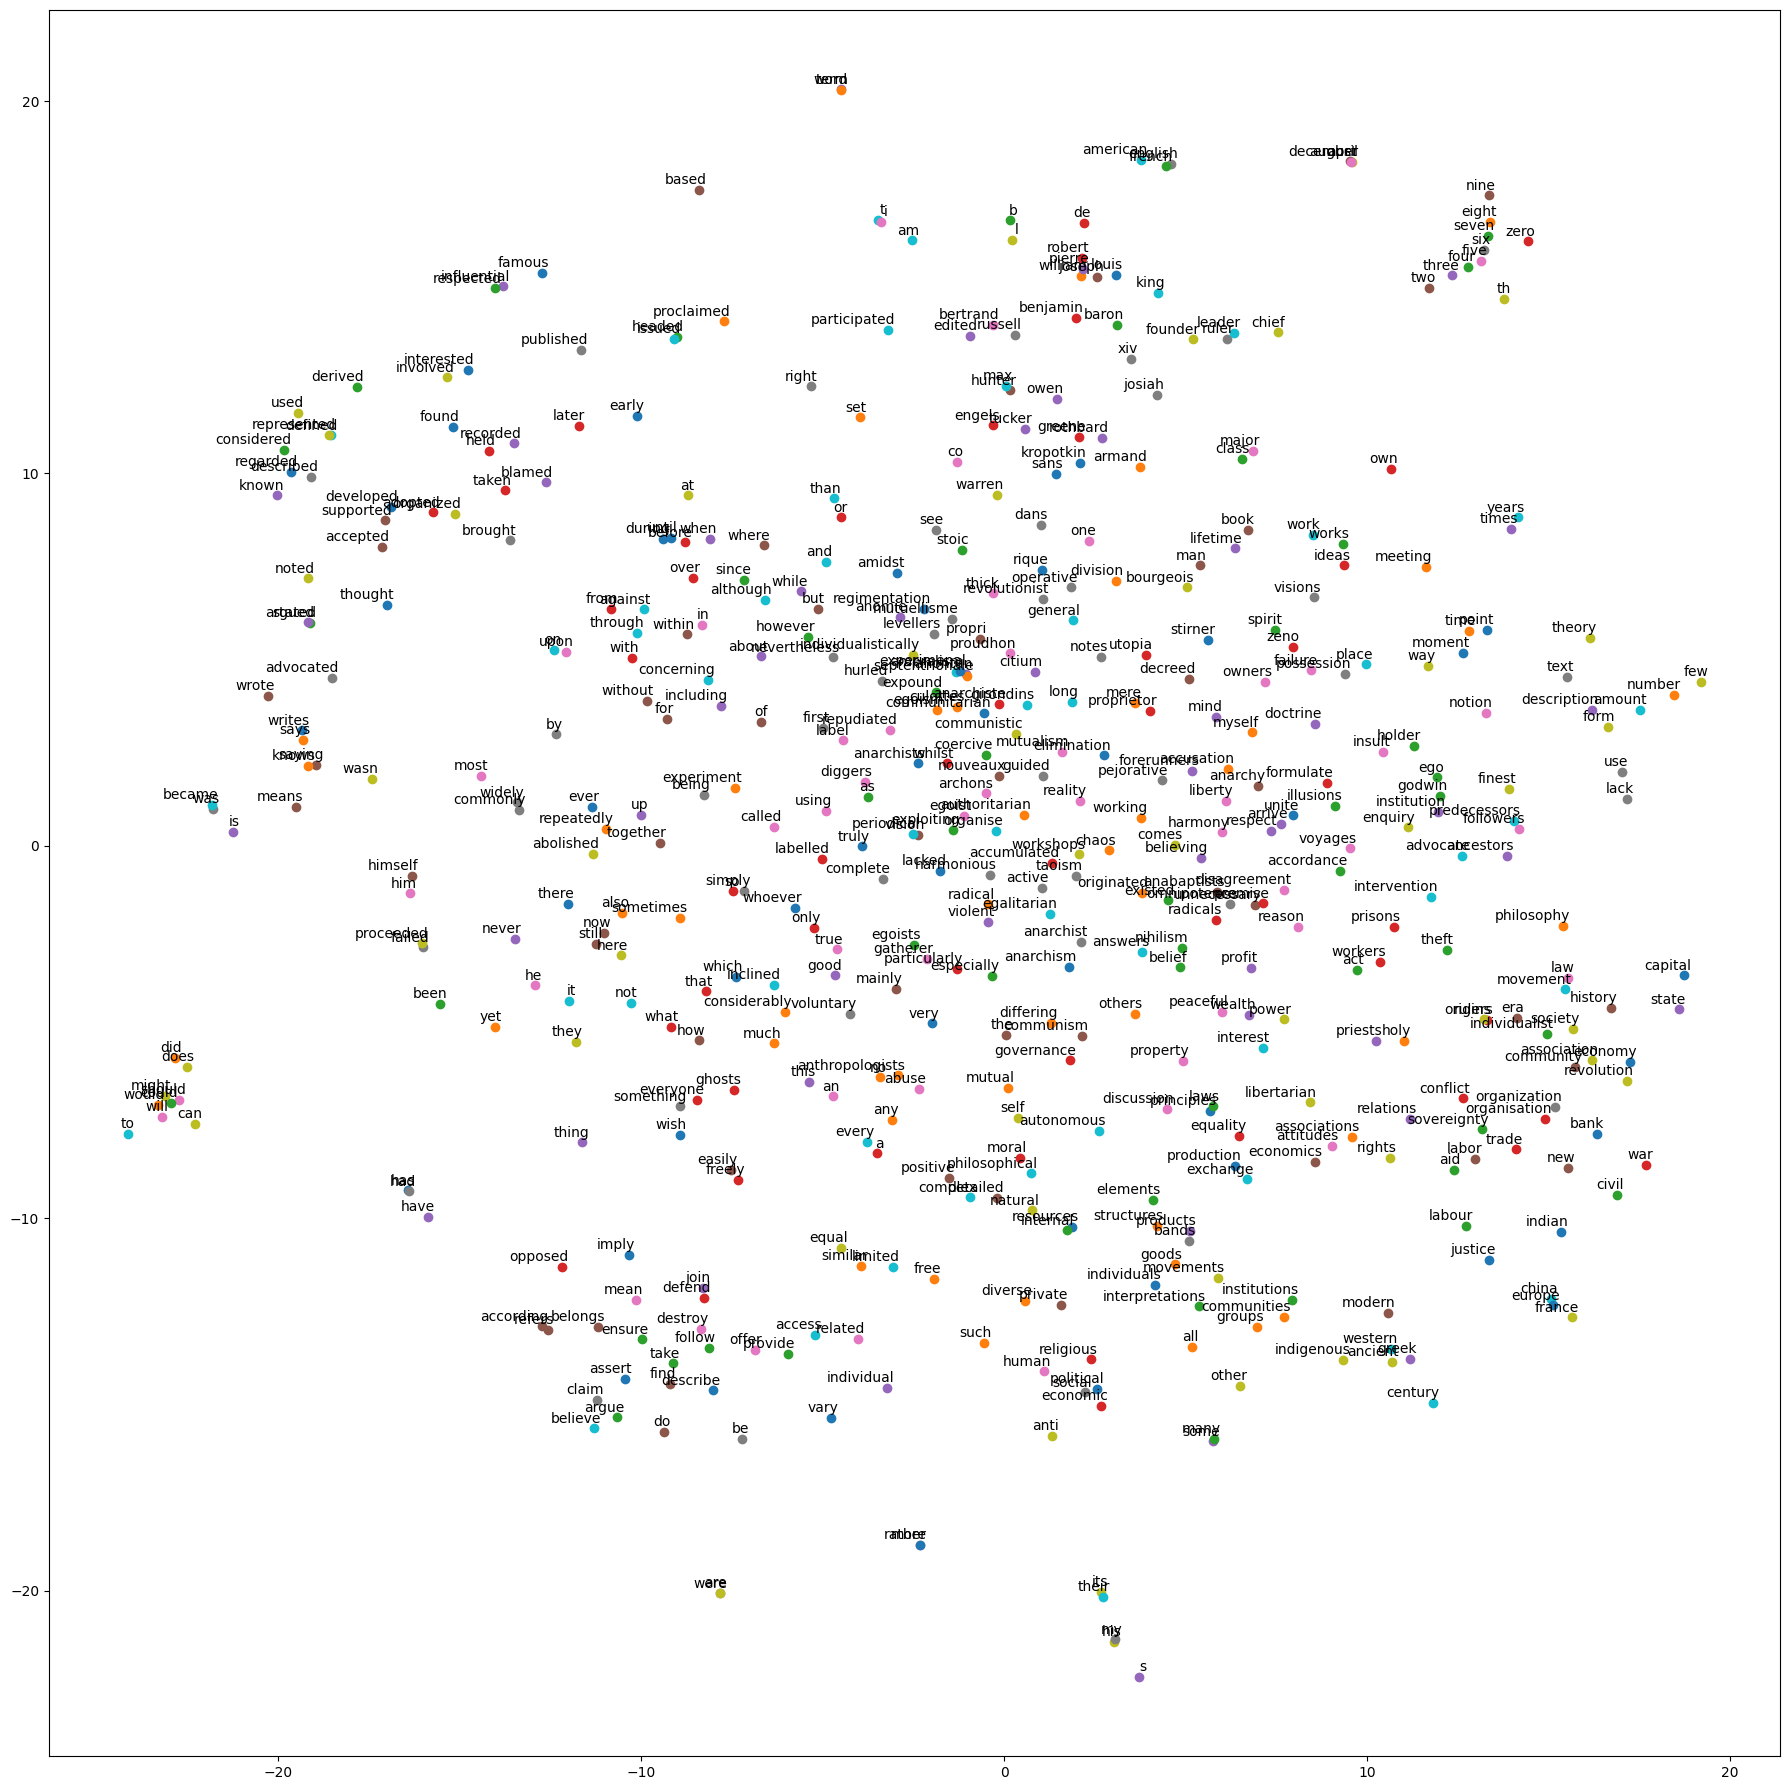

In [18]:
# --- same plotting helper you had ---
def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    import matplotlib.pyplot as plt

    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords="offset points", ha="right", va="bottom")
    plt.tight_layout()
    plt.show()


# --- PyTorch Word2Vec → get embeddings & labels ---
import numpy as np
from sklearn.manifold import TSNE

# If you already defined get_embeddings(model), you can use it; otherwise:
# emb_matrix = model.in_embed.weight.detach().cpu().numpy()
emb_matrix = model.in_embed.weight.detach().cpu().numpy()  # [V, D]
id_to_word = vocab.id2word  # list of tokens length V

# --- choose how many words to plot ---
plot_only = min(500, emb_matrix.shape[0])  # keep your original 500 default

# t-SNE config (keep your style, but make perplexity safe for small N)
perplexity = min(30, max(5, plot_only // 10))
tsne = TSNE(
    n_components=2,
    init="pca",
    perplexity=perplexity,
    learning_rate="auto",
    # method="barnes_hut" is default for 2D; keeping default is fine for N<=few thousands
)

# --- fit & plot ---
low_dim_embs = tsne.fit_transform(emb_matrix[:plot_only, :])  # [plot_only, 2]
labels = [id_to_word[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)